<a href="https://colab.research.google.com/github/FREDY129053/Practise_Temp/blob/main/Practise_Veg_Fru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Подгрузка данных из датасета**

---



In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle  # Установка зависимости для скачки датасета

In [ ]:
from google.colab import files

files.upload()  # Загрузка файла с данными от Kaggle API

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fredy129053","key":"732172104435df3745774c6e74467316"}'}

In [ ]:
!mkdir ~/.kaggle  # Создание папки для данных Kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/  # Перенос файла в папку

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json  # Задаем права на файл

In [ ]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition  # Скачиваем датасет

100% 1.98G/1.98G [00:28<00:00, 97.9MB/s]
100% 1.98G/1.98G [00:28<00:00, 75.7MB/s]


In [ ]:
!unzip fruit-and-vegetable-image-recognition.zip  # Распаковываем датасет

In [ ]:
!mkdir /content/drive/MyDrive/Fruits_and_Vegetables_Datset

In [ ]:
!cp -r /content/test /content/drive/MyDrive/Fruits_and_Vegetables_Datset/test

In [ ]:
!cp -r /content/train /content/drive/MyDrive/Fruits_and_Vegetables_Datset/train

In [ ]:
!cp -r /content/validation /content/drive/MyDrive/Fruits_and_Vegetables_Datset/validation

## Аугментация картинок

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Путь к папке с изображениями
folder_path = "/content/drive/MyDrive/Fruits_and_Vegetables_Datset/train"

# Количество аугментаций на каждую картинку
num_augmentations = 3

# Параметры аугментации
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=[1, 2],
    horizontal_flip=True,
    brightness_range=[0.2, 1.5],
    fill_mode='nearest'
)

# Получаем список всех подпапок
subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()][27:]

# Для каждой подпапки
for subfolder in subfolders:
    # Получаем список всех файлов изображений
    image_files = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith(('.png', '.jpg', '.jpeg'))]

    # Для каждого изображения
    for image_file in image_files:
        # Загружаем изображение и преобразуем его в массив
        img = load_img(image_file)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # Генерируем и сохраняем аугментации
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=subfolder, save_prefix='MY_', save_format='jpeg'):
            i += 1
            if i >= num_augmentations:
                break

In [ ]:
import os

# Путь к папке с изображениями
folder_path = "путь_к_папке"

# Получаем список всех подпапок
subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

# Для каждой подпапки
for subfolder in subfolders:
    # Получаем список всех файлов изображений с префиксом "MY_"
    my_image_files = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.startswith('MY_')]

    # Удаляем файлы с префиксом "MY_"
    for my_image_file in my_image_files:
        os.remove(my_image_file)


## Тест модели MobileNet V3 Large

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

import tensorflow as tf

w, h = 224, 224

training_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_and_Vegetables_Datset/train',
    labels='inferred',  # Формирование уровней на основе структуры датасета (яблоко, бананы и тд)
    label_mode='categorical',  # Режим уровней и создание (в данном случае) векторной формы уровней
    class_names=None,  # Список классов (папки итак отсортированы, можно не ставить)
    color_mode='rgb',  # Режим картинок
    batch_size=32,
    image_size=(w, h),
    shuffle=True,
    seed=42,  # Смысл жизни
    validation_split=None,
    subset=None,
    interpolation='bilinear',  # Нужно для алгоритма сжатия картинок
    follow_links=False,  # Переход по символьным ссылкам папок нахер
    crop_to_aspect_ratio=False  # обрезать тоже не надо
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_and_Vegetables_Datset/validation',
    labels='inferred',  # Формирование уровней на основе структуры датасета (яблоко, бананы и тд)
    label_mode='categorical',  # Режим уровней и создание (в данном случае) векторной формы уровней
    class_names=None,  # Список классов (папки итак отсортированы, можно не ставить)
    color_mode='rgb',  # Режим картинок
    batch_size=32,
    image_size=(w, h),
    shuffle=True,
    seed=42,  # Смысл жизни
    validation_split=None,
    subset=None,
    interpolation='bilinear',  # Нужно для алгоритма сжатия картинок
    follow_links=False,  # Переход по символьным ссылкам папок нахер
    crop_to_aspect_ratio=False  # обрезать тоже не надо
)

base_model = MobileNetV3Large(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
preds = Dense(36, activation='softmax')(x)

model = Model(inputs=base_model.inputs, outputs=preds)
model.summary()

Found 11961 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


12683000/12683000 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, None, None, 16)       432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, None, None, 16)       64        ['Conv[0][0]']                
 lization)                   

In [ ]:
for layer in model.layers[:-5]:
    layer.trainable = False

In [ ]:
epochs = 8
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(training_set, validation_data=validation_set, epochs=epochs)

Epoch 1/8
374/374 [==============================] - 1793s 5s/step - loss: 1.5677 - accuracy: 0.5860 - val_loss: 0.3428 - val_accuracy: 0.8974
Epoch 2/8
374/374 [==============================] - 546s 1s/step - loss: 0.6126 - accuracy: 0.8103 - val_loss: 0.2462 - val_accuracy: 0.9259
Epoch 3/8
374/374 [==============================] - 534s 1s/step - loss: 0.4177 - accuracy: 0.8724 - val_loss: 0.2173 - val_accuracy: 0.9345
Epoch 4/8
374/374 [==============================] - 527s 1s/step - loss: 0.2907 - accuracy: 0.9124 - val_loss: 0.2025 - val_accuracy: 0.9544
Epoch 5/8
374/374 [==============================] - 526s 1s/step - loss: 0.2110 - accuracy: 0.9400 - val_loss: 0.1924 - val_accuracy: 0.9487
Epoch 6/8
374/374 [==============================] - 522s 1s/step - loss: 0.1509 - accuracy: 0.9582 - val_loss: 0.1671 - val_accuracy: 0.9516
Epoch 7/8
374/374 [==============================] - 524s 1s/step - loss: 0.1043 - accuracy: 0.9753 - val_loss: 0.1536 - val_accuracy: 0.9601
Epoch

In [ ]:
import json

model.save('/content/drive/MyDrive/model_MNv3LARGE.keras')
with open('/content/drive/MyDrive/train_history_MNv3LARGE', 'w') as f:
  json.dump(history.history, f)

## Тест модели NASNetLarge

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

import tensorflow as tf

w, h = 331, 331

training_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_and_Vegetables_Datset/train',
    labels='inferred',  # Формирование уровней на основе структуры датасета (яблоко, бананы и тд)
    label_mode='categorical',  # Режим уровней и создание (в данном случае) векторной формы уровней
    class_names=None,  # Список классов (папки итак отсортированы, можно не ставить)
    color_mode='rgb',  # Режим картинок
    batch_size=32,
    image_size=(w, h),
    shuffle=True,
    seed=42,  # Смысл жизни
    validation_split=None,
    subset=None,
    interpolation='bilinear',  # Нужно для алгоритма сжатия картинок
    follow_links=False,  # Переход по символьным ссылкам папок нахер
    crop_to_aspect_ratio=False  # обрезать тоже не надо
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_and_Vegetables_Datset/validation',
    labels='inferred',  # Формирование уровней на основе структуры датасета (яблоко, бананы и тд)
    label_mode='categorical',  # Режим уровней и создание (в данном случае) векторной формы уровней
    class_names=None,  # Список классов (папки итак отсортированы, можно не ставить)
    color_mode='rgb',  # Режим картинок
    batch_size=32,
    image_size=(w, h),
    shuffle=True,
    seed=42,  # Смысл жизни
    validation_split=None,
    subset=None,
    interpolation='bilinear',  # Нужно для алгоритма сжатия картинок
    follow_links=False,  # Переход по символьным ссылкам папок нахер
    crop_to_aspect_ratio=False  # обрезать тоже не надо
)

base_model = NASNetLarge(input_shape = (331, 331, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable=False

model=Sequential()
model.add(base_model)
model.add(tf.keras.layers.BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(36, activation='softmax'))
model.summary()

Found 11961 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 11, 11, 4032)      84916818  
                                                                 
 batch_normalization (Batch  (None, 11, 11, 4032)      16128     
 Normalization)                                                  
                                                                 
 global_average_pooling2d_1  (None, 4032)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout (Dropout)           (None, 4032)              0         
                                                                 
 dropout_1 (Dropout)         (None, 4032)              0         
                                      

In [ ]:
epochs = 15
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(training_set, validation_data=validation_set, epochs=epochs)

Epoch 1/15
  2/374 [..............................] - ETA: 4:22:50 - loss: 3.8027 - accuracy: 0.0469

In [ ]:
import json

model.save('/content/drive/MyDrive/model_NasNet.keras')
with open('/content/drive/MyDrive/train_history_NasNet', 'w') as f:
  json.dump(history.history, f)

## Тест модели MobileNetV3 Small

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

import tensorflow as tf

w, h = 224, 224

training_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_and_Vegetables_Datset/train',
    labels='inferred',  # Формирование уровней на основе структуры датасета (яблоко, бананы и тд)
    label_mode='categorical',  # Режим уровней и создание (в данном случае) векторной формы уровней
    class_names=None,  # Список классов (папки итак отсортированы, можно не ставить)
    color_mode='rgb',  # Режим картинок
    batch_size=32,
    image_size=(w, h),
    shuffle=True,
    seed=42,  # Смысл жизни
    validation_split=None,
    subset=None,
    interpolation='bilinear',  # Нужно для алгоритма сжатия картинок
    follow_links=False,  # Переход по символьным ссылкам папок нахер
    crop_to_aspect_ratio=False  # обрезать тоже не надо
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_and_Vegetables_Datset/validation',
    labels='inferred',  # Формирование уровней на основе структуры датасета (яблоко, бананы и тд)
    label_mode='categorical',  # Режим уровней и создание (в данном случае) векторной формы уровней
    class_names=None,  # Список классов (папки итак отсортированы, можно не ставить)
    color_mode='rgb',  # Режим картинок
    batch_size=32,
    image_size=(w, h),
    shuffle=True,
    seed=42,  # Смысл жизни
    validation_split=None,
    subset=None,
    interpolation='bilinear',  # Нужно для алгоритма сжатия картинок
    follow_links=False,  # Переход по символьным ссылкам папок нахер
    crop_to_aspect_ratio=False  # обрезать тоже не надо
)

base_model = MobileNetV3Small(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
preds = Dense(36, activation='softmax')(x)

model = Model(inputs=base_model.inputs, outputs=preds)
model.summary()

Found 11961 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling_1[0][0]']            
                                16)                                                         

In [ ]:
for layer in model.layers[:-5]:
    layer.trainable = False

In [ ]:
epochs = 6
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(training_set, validation_data=validation_set, epochs=epochs)

Epoch 1/6
374/374 [==============================] - 1794s 5s/step - loss: 1.9235 - accuracy: 0.4986 - val_loss: 0.5382 - val_accuracy: 0.8746
Epoch 2/6
374/374 [==============================] - 394s 1s/step - loss: 0.9170 - accuracy: 0.7282 - val_loss: 0.4023 - val_accuracy: 0.8889
Epoch 3/6
374/374 [==============================] - 346s 914ms/step - loss: 0.7037 - accuracy: 0.7865 - val_loss: 0.3442 - val_accuracy: 0.8917
Epoch 4/6
374/374 [==============================] - 358s 945ms/step - loss: 0.5735 - accuracy: 0.8254 - val_loss: 0.2922 - val_accuracy: 0.9202
Epoch 5/6
374/374 [==============================] - 362s 956ms/step - loss: 0.4707 - accuracy: 0.8555 - val_loss: 0.2704 - val_accuracy: 0.9231
Epoch 6/6
374/374 [==============================] - 431s 1s/step - loss: 0.3950 - accuracy: 0.8795 - val_loss: 0.2296 - val_accuracy: 0.9373


In [ ]:
model.save('/content/drive/MyDrive/MODEL_MOBILENET_V3.keras')

## Тест модели VGG19

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

w, h = 224, 224

training_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_and_Vegetables_Datset/train',
    labels='inferred',  # Формирование уровней на основе структуры датасета (яблоко, бананы и тд)
    label_mode='categorical',  # Режим уровней и создание (в данном случае) векторной формы уровней
    class_names=None,  # Список классов (папки итак отсортированы, можно не ставить)
    color_mode='rgb',  # Режим картинок
    batch_size=32,
    image_size=(w, h),
    shuffle=True,
    seed=42,  # Смысл жизни
    validation_split=None,
    subset=None,
    interpolation='bilinear',  # Нужно для алгоритма сжатия картинок
    follow_links=False,  # Переход по символьным ссылкам папок нахер
    crop_to_aspect_ratio=False  # обрезать тоже не надо
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_and_Vegetables_Datset/validation',
    labels='inferred',  # Формирование уровней на основе структуры датасета (яблоко, бананы и тд)
    label_mode='categorical',  # Режим уровней и создание (в данном случае) векторной формы уровней
    class_names=None,  # Список классов (папки итак отсортированы, можно не ставить)
    color_mode='rgb',  # Режим картинок
    batch_size=32,
    image_size=(w, h),
    shuffle=True,
    seed=42,  # Смысл жизни
    validation_split=None,
    subset=None,
    interpolation='bilinear',  # Нужно для алгоритма сжатия картинок
    follow_links=False,  # Переход по символьным ссылкам папок нахер
    crop_to_aspect_ratio=False  # обрезать тоже не надо
)

conv_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))

x = tf.keras.layers.Flatten()(conv_model.output)

x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)

predictions = tf.keras.layers.Dense(36, activation='softmax')(x)

full_model = tf.keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()


Found 11961 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                         

In [ ]:
for layer in conv_model.layers:
    layer.trainable = False

In [ ]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
                  metrics=['accuracy'])

history = full_model.fit(
    training_set,
    validation_data = validation_set,
    workers=10,
    epochs=5,
)

Epoch 1/5
265/374 [====================>.........] - ETA: 42:51 - loss: 0.1907 - accuracy: 0.1491

KeyboardInterrupt: 

In [ ]:
full_model.save('/content/drive/MyDrive/MODEL_VGG19_11KI.keras')

In [ ]:
full_model.save('/content/drive/MyDrive/MODEL_VGG19_W.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import json

with open('/content/drive/MyDrive/train_history_VGG19', 'w') as f:
  json.dump(history.history, f)

## Создание тг бота

In [ ]:
!pip install aiogram

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
%mkdir /content/temp

In [ ]:
import asyncio
import logging
import numpy as np
import tensorflow as tf

from aiogram import Bot, Dispatcher, types
from aiogram.filters.command import Command
from aiogram import F


bot = Bot(token='6882546934:AAFuE68_kEXz5Iw9lchWi-anbRrx-Tb5FkM')
dp = Dispatcher()
classes = [
    'Яблоко', 'Банан', 'Свекла', 'Болгарский перец',
    'Капуста', 'Стручковый перец', 'Морковь', 'Цветная капуста',
    'Перец чили', 'Кукуруза', 'Огурец', 'Баклажан',
    'Чеснок', 'Имбирь', 'Виноград', 'Халапеньо',
    'Киви', 'Лимон', 'Латук', 'Манго',
    'Лук', 'Апельсин', 'Паприка', 'Груша',
    'Горох', 'Ананас', 'Гранат', 'Картофель',
    'Редиска', 'Соевые бобы', 'Шпинат', 'Сладкая кукуруза',
    'Батат', 'Помидор', 'Репа', 'Арбуз'
]


@dp.message(Command('start'))
async def start_command(message: types.Message):
    await message.answer('Привет, чепушила')


@dp.message(F.photo)
async def get_photo_and_result(message: types.Message, bot: Bot):
    image_path = f'temp/{message.photo[1].file_id}.jpg'
    await bot.download(
        message.photo[-1],
        destination=image_path
    )

    await message.reply('Фото загружено!!!')
    await message.answer('Секунду...')
    result = get_prediction(image_path)
    await message.answer(result)



def get_prediction(image_path):
  model = tf.keras.models.load_model('/content/drive/MyDrive/model_MNv3LARGE.keras')
  image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  input_arr = np.array([input_arr])  # В двумерную матрицу

  prediction = model.predict(input_arr)
  result_index_of_prediction = np.where(prediction[0] == max(prediction[0]))

  answer = f"Я думаю на картинке {classes[result_index_of_prediction[0][0]]}"

  return answer


async def main():
    await dp.start_polling(bot)



await main()


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 2s 2s/step


##**Создание модели**

### Импорт либ и обработка датасета

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
w, h = 128, 128

training_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_and_Vegetables_Datset/train',
    labels='inferred',  # Формирование уровней на основе структуры датасета (яблоко, бананы и тд)
    label_mode='categorical',  # Режим уровней и создание (в данном случае) векторной формы уровней
    class_names=None,  # Список классов (папки итак отсортированы, можно не ставить)
    color_mode='rgb',  # Режим картинок
    batch_size=32,
    image_size=(w, h),
    shuffle=True,
    seed=42,  # Смысл жизни
    validation_split=None,
    subset=None,
    interpolation='bilinear',  # Нужно для алгоритма сжатия картинок
    follow_links=False,  # Переход по символьным ссылкам папок нахер
    crop_to_aspect_ratio=False  # обрезать тоже не надо
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_and_Vegetables_Datset/validation',
    labels='inferred',  # Формирование уровней на основе структуры датасета (яблоко, бананы и тд)
    label_mode='categorical',  # Режим уровней и создание (в данном случае) векторной формы уровней
    class_names=None,  # Список классов (папки итак отсортированы, можно не ставить)
    color_mode='rgb',  # Режим картинок
    batch_size=32,
    image_size=(w, h),
    shuffle=True,
    seed=42,  # Смысл жизни
    validation_split=None,
    subset=None,
    interpolation='bilinear',  # Нужно для алгоритма сжатия картинок
    follow_links=False,  # Переход по символьным ссылкам папок нахер
    crop_to_aspect_ratio=False  # обрезать тоже не надо
)

Found 3152 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


### Создание модели

In [ ]:
seq_model = tf.keras.models.Sequential()

#### Создание слоев

In [ ]:
seq_model.add(tf.keras.layers.Conv2D(
    filters=32,  # Опционально
    kernel_size=3,
    padding='same',
    activation='relu',
    input_shape=[w, h, 3],
))

seq_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))

seq_model.add(tf.keras.layers.MaxPool2D(
    pool_size=2,
    strides=2
))

In [ ]:
seq_model.add(tf.keras.layers.Dropout(0.25))

In [ ]:
seq_model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=3,
    padding='same',
    activation='relu',
))

seq_model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=3,
    activation='relu',
))

seq_model.add(tf.keras.layers.MaxPool2D(
    pool_size=2,
    strides=2
))

In [ ]:
seq_model.add(tf.keras.layers.Dropout(0.25))

In [ ]:
seq_model.add(tf.keras.layers.Flatten())

In [ ]:
seq_model.add(tf.keras.layers.Dense(
    units=256,  # Опционально
    activation='relu'
))

seq_model.add(tf.keras.layers.Dense(
    units=128,  # Опционально
    activation='relu'
))

In [ ]:
seq_model.add(tf.keras.layers.Dropout(0.5))  # Чтобы избежать переобучения

In [ ]:
seq_model.add(tf.keras.layers.Dense(units=36, activation='softmax'))  # Выходной слой. 36 потому что у нас 36 классов!!!

###Обучение модели

In [ ]:
# my_optimizer = 'adam'
my_optimizer = tf.keras.optimizers.Adadelta()

seq_model.compile(optimizer=my_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        36928     
                                                      

In [ ]:
train_history = seq_model.fit(x=training_set, validation_data=validation_set, epochs=35)

Epoch 1/35
99/99 [==============================] - 525s 5s/step - loss: 34.6497 - accuracy: 0.0270 - val_loss: 6.6567 - val_accuracy: 0.0199
Epoch 2/35
99/99 [==============================] - 368s 4s/step - loss: 18.5195 - accuracy: 0.0286 - val_loss: 5.5751 - val_accuracy: 0.0171
Epoch 3/35
99/99 [==============================] - 346s 3s/step - loss: 14.3419 - accuracy: 0.0320 - val_loss: 4.9643 - val_accuracy: 0.0199


KeyboardInterrupt: 

In [ ]:
seq_model.save('trained_model_updated.h5')

In [ ]:
import json

with open('train_history', 'w') as f:
  json.dump(train_history.history, f)

In [ ]:
print(f"Точность модели = {train_history.history['val_accuracy'][-1] * 100:.2f}%")

Точность модели = 95.16%


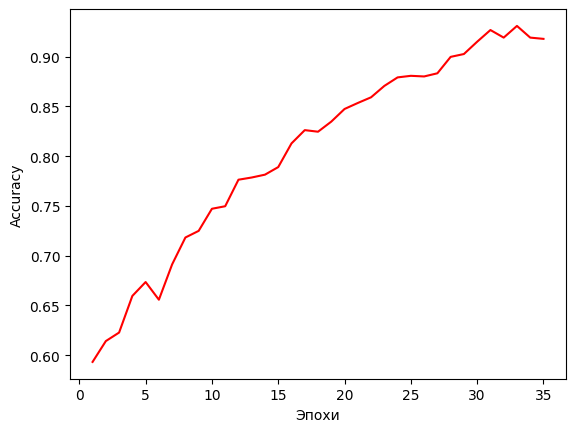

In [ ]:
epochs = [i for i in range(1, 36)]

plt.plot(epochs, train_history.history['accuracy'], color='r')
plt.xlabel('Эпохи')
plt.ylabel('Accuracy')
plt.show();

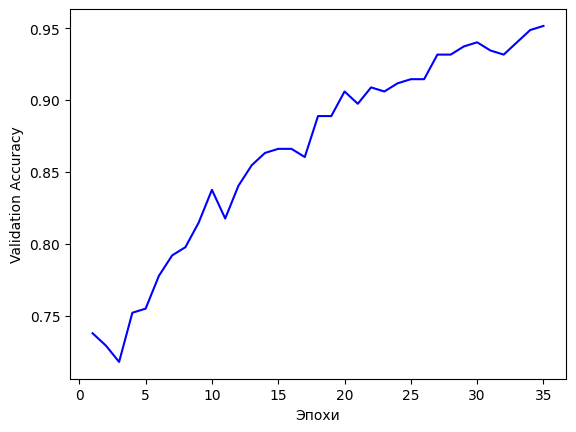

In [ ]:
plt.plot(epochs, train_history.history['val_accuracy'], color='b')
plt.xlabel('Эпохи')
plt.ylabel('Validation Accuracy')
plt.show();

##Загрузка модели и тест ее

In [ ]:
model = tf.keras.models.load_model('/content/trained_model_updated.h5')

In [ ]:
image_path = '/content/i.webp'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(64, 64))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # В двумерную матрицу

prediction = model.predict(input_arr)
print(prediction[0])

1/1 [==============================] - 0s 49ms/step
[7.03286378e-06 2.43377275e-04 4.55246573e-06 2.10757687e-04
 2.82172238e-07 3.90843452e-05 6.60500769e-03 1.21239223e-08
 4.71699906e-07 9.86566651e-04 2.99125986e-08 9.11170972e-10
 6.66140849e-08 8.86245004e-07 5.62566072e-07 5.09376650e-06
 8.28787279e-07 1.26622955e-03 1.72777004e-09 2.53893148e-07
 1.08986974e-07 4.86476565e-05 9.14013526e-06 5.23818744e-06
 3.09170896e-12 3.28422822e-02 6.32756855e-04 2.79723966e-10
 1.10029141e-05 2.66433819e-10 7.70489852e-11 9.57071364e-01
 9.99017709e-12 7.23175935e-06 7.34142304e-07 3.08251657e-07]


In [ ]:
result_index_of_prediction = np.where(prediction[0] == max(prediction[0]))

test_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_and_Vegetables_Datset/test',
    labels='inferred',  # Формирование уровней на основе структуры датасета (яблоко, бананы и тд)
    label_mode='categorical',  # Режим уровней и создание (в данном случае) векторной формы уровней
    class_names=None,  # Список классов (папки итак отсортированы, можно не ставить)
    color_mode='rgb',  # Режим картинок
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=42,  # Смысл жизни
    validation_split=None,
    subset=None,
    interpolation='bilinear',  # Нужно для алгоритма сжатия картинок
    follow_links=False,  # Переход по символьным ссылкам папок нахер
    crop_to_aspect_ratio=False  # обрезать тоже не надо
)

print(f"Result of prediction: \nOn image is {test_set.class_names[result_index_of_prediction[0][0]]}")

Found 359 files belonging to 36 classes.
Result of prediction: 
On image is sweetcorn
